# Notes
Once the mounting above is complete, I'm thinking we manage our directory like:
- `models/` - maybe we can just store our models here?
- `results/` - any output statistics/graphs to visualize our results
- `utils/` - assuming we'll have at least some utility helper functions/classes

# Step 0a. Initial Setup

# Step 0b. Dependencies/Imports

In [1]:
from networks.FasterRCNN import FasterRCNN
from networks.MaskRCNN import MaskRCNN
from utils import AnchorBoxUtil, DataManager, ImageUtil, TrainingUtil
import torch
import torch.nn as nn
import gc

%load_ext autoreload
%autoreload 2

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = 'cpu'
print('Current device is: {}'.format(device))

Current device is: cuda


# Step 0c. Data Preparation

In [3]:
# data parameters
dataset_name = "voc-2007"
num_train = None
num_val = None
h_img_std = 480 # standard image height to resize to
w_img_std = 640 # standard image width to resize to

# # initial import from fiftyone.zoo
# dataset_train = foz.load_zoo_dataset(
#     dataset_name,
#     splits=["train"],
#     max_samples=num_train
# )
# dataset_val = foz.load_zoo_dataset(
#     dataset_name,
#     splits=["validation"],
#     max_samples=num_val
# )

# load images into tensors and parse out the target information (bounding boxes and labels)
data_train, data_val, str2id, id2str = DataManager.load_data(dataset_name, num_train, num_val, (h_img_std, w_img_std))

Split 'train' already downloaded
Ignoring unsupported parameter 'label_types' for importer type <class 'fiftyone.utils.data.importers.FiftyOneImageDetectionDatasetImporter'>
Loading existing dataset 'voc-2007-train-None'. To reload from disk, either delete the existing dataset or provide a custom `dataset_name` to use
Split 'validation' already downloaded
Ignoring unsupported parameter 'label_types' for importer type <class 'fiftyone.utils.data.importers.FiftyOneImageDetectionDatasetImporter'>
Loading existing dataset 'voc-2007-validation-None'. To reload from disk, either delete the existing dataset or provide a custom `dataset_name` to use
Pre-processing [Validation] Dataset: 100%|██████████| 2510/2510 [00:20<00:00, 119.72it/s]


# Step 0d. Examples

## Example Using ImageUtil

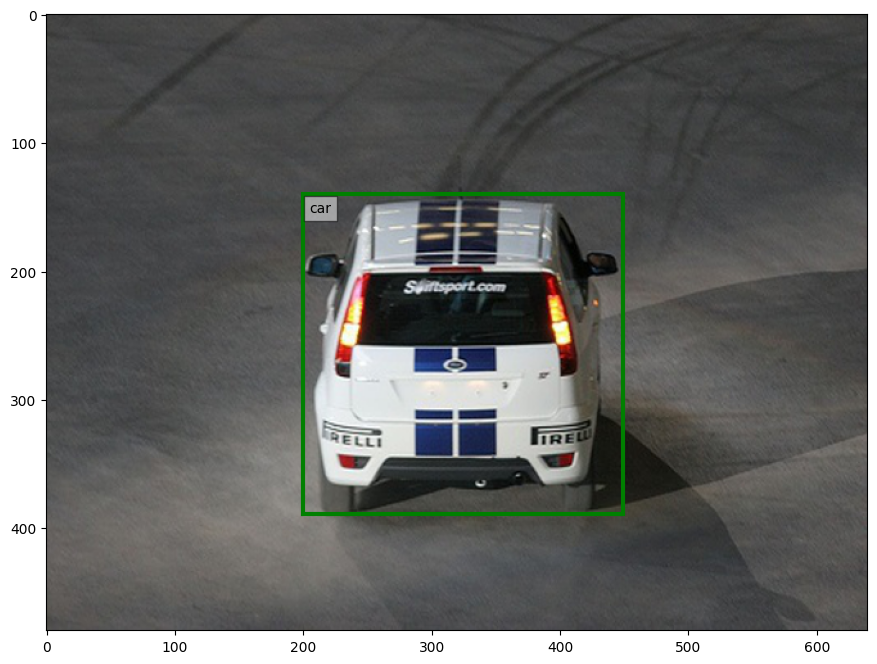

In [4]:
# data visualization tool
# session = fo.launch_app(dataset_train)

# example for using ImageUtil
example_idx = 0
# id_cats = {cat_ids[key]: key for key in cat_ids.keys()}                            # reverse the category ids
example_image = data_train.images[example_idx].long()                              # look up the image and convert to long
example_labels = [id2str[key] for key in data_train.labels[example_idx].tolist()] # get the actual label string(s)
example_bboxes = data_train.bboxes[example_idx]                                    # get this sample's bounding box(es) (format is: [x_min, y_min, x_max, y_max])
ImageUtil.build_image(example_image, example_bboxes, example_labels, 'g')

## Generating Positive/Negative Anchors

G:\Dropbox (GaTech)\CS7643_DL\Mask_R-CNN\utils\ImageUtil.py:30: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


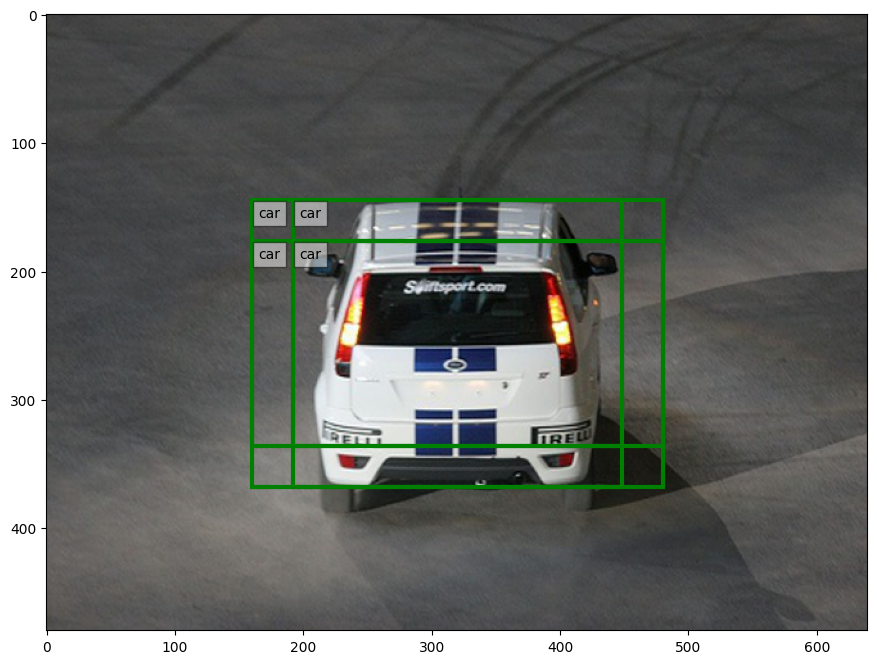

In [12]:
# generate anchor boxes
scales = [2, 4, 6]
ratios = [0.5, 1, 1.5]
anchor_bboxes = AnchorBoxUtil.generate_anchor_boxes(15, 20, scales, ratios, 'cpu')
all_anchor_bboxes = anchor_bboxes.repeat(data_train.n_samples, 1, 1, 1, 1)
train_bboxes = AnchorBoxUtil.scale_bboxes(data_train.bboxes, 1 / 32, 1 / 32)

# evaluate for positive and negative anchors
pos_thresh = 0.68
neg_thresh = 0.3
pos_inds_flat, neg_inds_flat, pos_scores, pos_offsets, pos_labels, pos_bboxes, pos_points, neg_points, pos_inds_batch = AnchorBoxUtil.evaluate_anchor_bboxes(all_anchor_bboxes, train_bboxes, data_train.labels, pos_thresh, neg_thresh)

top_n = 10
pos_classes = pos_labels[pos_inds_batch == example_idx][:top_n]
pos_bboxes = pos_points[pos_inds_batch == example_idx][:top_n]

# display positives
lab = [id2str[i] for i in pos_classes.tolist()]
pos_bboxes = AnchorBoxUtil.scale_bboxes(pos_bboxes, 32, 32)
ImageUtil.build_image(example_image, pos_bboxes, lab, 'g', show=True)

# Step 1. Faster R-CNN

## Step 1a. Initialize Model

In [4]:
# parameters
img_size = (h_img_std, w_img_std)
roi_size = (3, 3)
n_labels = len(str2id) - 1
pos_thresh = 0.68
neg_thresh = 0.30
nms_thresh = 0.7
top_n = 128
hidden_dim = 512
dropout = 0.1
backbone_size = (1024, 30, 40)
backbone = 'resnet50'

model = FasterRCNN(img_size, roi_size, n_labels, top_n, pos_thresh, neg_thresh, nms_thresh, hidden_dim, dropout, backbone, device=device)

## Step 1b. Training

------------------------------------------------------------
Running Epoch: 01 / 15
100%|██████████| 156/156 [00:54<00:00,  2.85it/s]
  Training Loss: 0.32, Validation Loss 0.25
------------------------------------------------------------
Running Epoch: 02 / 15
100%|██████████| 156/156 [00:54<00:00,  2.86it/s]
  Training Loss: 0.25, Validation Loss 0.24
------------------------------------------------------------
Running Epoch: 03 / 15
100%|██████████| 156/156 [00:54<00:00,  2.88it/s]
  Training Loss: 0.22, Validation Loss 0.23
------------------------------------------------------------
Running Epoch: 04 / 15
100%|██████████| 156/156 [00:54<00:00,  2.88it/s]
  Training Loss: 0.21, Validation Loss 0.23
------------------------------------------------------------
Running Epoch: 05 / 15
100%|██████████| 156/156 [00:54<00:00,  2.88it/s]
  Training Loss: 0.19, Validation Loss 0.23
------------------------------------------------------------
Running Epoch: 06 / 15
100%|██████████| 156/156 [

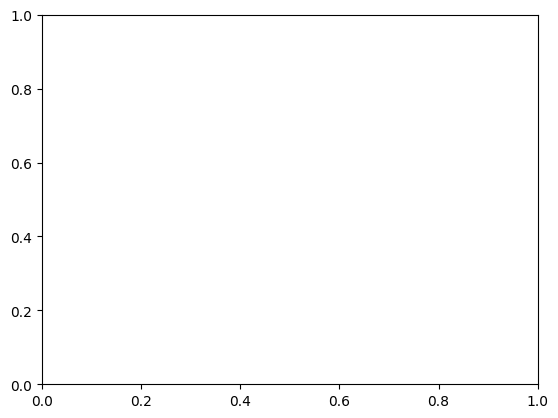

In [5]:
# parameters
learning_rate = 1e-3
momentum = 0.95
num_epochs = 15
batch_size = 16

# initialize optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)

# run training
loss_results = TrainingUtil.train_model(model, optimizer, data_train, data_val, num_epochs, batch_size, device=device, save=True)

In [5]:
0model.load_state_dict(torch.load('G:\\Dropbox (GaTech)\\CS7643_DL\\Mask_R-CNN\\results\\models\\2024-04-14_210450\\model.pt'))

<All keys matched successfully>

## Step 1c. Evaluation

In [52]:
model.eval()
proposals, labels = model.evaluate(data_train.images[0:10].to(device), device=device)

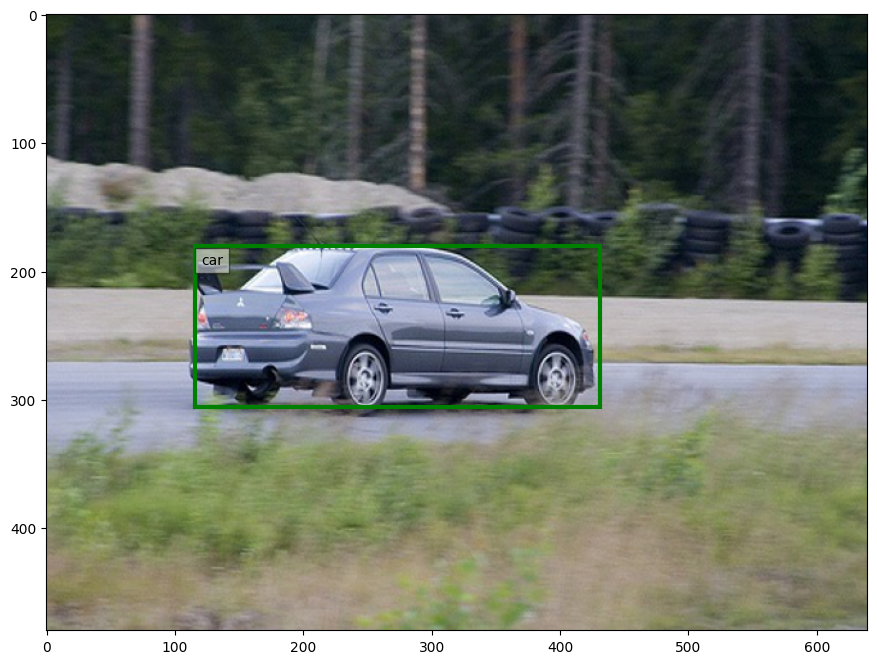

In [48]:
eval_idx = 3
# id_cats = {cat_ids[key]: key for key in cat_ids.keys()}                            # reverse the category ids
example_image = data_train.images[eval_idx].long()                              # look up the image and convert to long
example_labels = [id2str[key] for key in data_train.labels[eval_idx].tolist()] # get the actual label string(s)
example_bboxes = data_train.bboxes[eval_idx]                                    # get this sample's bounding box(es) (format is: [x_min, y_min, x_max, y_max])
ImageUtil.build_image(example_image, example_bboxes, example_labels, 'g')

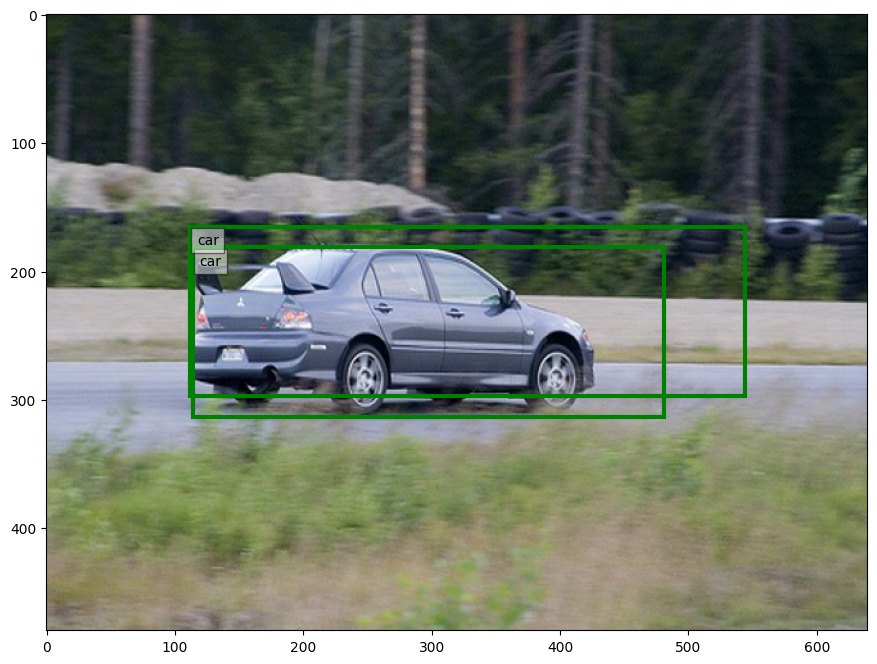

In [53]:
eval_labels = [id2str[key] for key in labels[eval_idx].tolist()] # get the actual label string(s)
eval_bboxes = proposals[eval_idx]                                    # get this sample's bounding box(es) (format is: [x_min, y_min, x_max, y_max])
ImageUtil.build_image(example_image, eval_bboxes, eval_labels, 'g')

In [15]:
labels

[tensor([5, 5, 4, 5, 4]),
 tensor([4, 4, 5, 5, 4, 5, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5]),
 tensor([8, 8, 5, 5, 8, 5, 5, 2, 5, 5, 5, 5, 5, 8, 5, 5, 5, 8, 5, 5, 5, 5, 5, 5,
         5, 5, 5]),
 tensor([5, 5, 5, 5]),
 tensor([8, 5, 5, 5, 8, 5, 5, 5, 8, 5, 5, 8, 5, 5, 5, 8, 5, 5, 5, 5, 5, 5, 5, 5,
         5, 8, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 8, 5, 5, 8, 5, 5, 5, 5, 5, 8, 8,
         8, 5, 8, 5, 5, 5])]

In [16]:
example_labels

['chair', 'chair', 'chair', 'chair', 'chair']

## Step 1d. Comparison Against Other Pre-Trained Models

In [ ]:
# # code is adapted from: https://pytorch.org/vision/stable/models.html

# from torchvision.models.detection import fasterrcnn_resnet50_fpn, FasterRCNN_ResNet50_FPN_Weights

# # initialize weights
# weights = FasterRCNN_ResNet50_FPN_Weights.DEFAULT

# # initialize model
# fpn_model = fasterrcnn_resnet50_fpn(weights=weights)

# # transform the input images
# preprocess = weights.transforms()
# image_set = [preprocess(image) for image in x_train]

# # evaluate the images
# output = fpn_model(image_set)

# # interpret the labels (bounding boxes live in output["boxes"])
# labels = [weights.meta["categories"][i] for i in output["labels"]]

## RPN implementations

In [ ]:
# RPN network
class RPN(nn.Module):
    """
    RPN network, outputs objectiveness scores per pixel, and bbox deltas (t_x, t_y, t_w, t_h) per pixel
    """

    def __init__(self, k, depth):
        super(RPN, self).__init__()

        self.conv = nn.Conv2d(in_channels=depth, out_channels=512, kernel_size=3, padding=1)
        self.conv_class = nn.Conv2d(in_channels=512, out_channels=2 * k, kernel_size=1)
        self.conv_regress = nn.Conv2d(in_channels=512, out_channels=4 * k, kernel_size=1)
        self.ReLU = nn.ReLU()
        self.SM = nn.Softmax(dim=2)

    def forward(self, features):
        batch_size = features.shape[0] # features are in size batch_size x channel_size x H x W
        features = self.ReLU(self.conv(features))

        rpn_objectivity = self.conv_class(features) # batch_size x scores x H x W, H and W are sizes of the feature map, not the original input image
        rpn_objectivity = rpn_objectivity.permute(0, 2, 3, 1)
        rpn_objectivity = rpn_objectivity.reshape(batch_size, -1, 2) # batch_size x (total # of anchors) x (yes/no score for classifying whether there is an object in bb)
        rpn_objectivity = self.SM(rpn_objectivity)
        rpn_objectivity = rpn_objectivity[:, :, 0]

        rpn_delta = self.conv_regress(features) # batch_size x bb_sizes x H x W, H and W are sizes of the feature map, not the original input image
        rpn_delta = rpn_delta.permute(0, 2, 3, 1)
        rpn_delta = rpn_delta.reshape(batch_size, -1, 4) # batch_size x (total # of anchors) x (4 bb size numbers)

        return rpn_objectivity, rpn_delta

In [ ]:
def gen_k_center_anchors(sizes, aspect_ratios):
    """
    Generates k 0-centered anchors, where k = len(scales) x len(aspect_ratios)
    :param sizes: tuple of scales, defined as sqrt(H x W)
    :param aspect_ratios: tuple of aspect_ratios, defined as W:H
    :return: tensor of anchors, k x 4, in format x1, y1, x2, y2
    """

    sizes = torch.as_tensor(sizes, dtype=torch.float32)
    aspect_ratios = torch.as_tensor(aspect_ratios)
    h_ratios = torch.sqrt(aspect_ratios)
    w_ratios = 1.0 / h_ratios

    h_ratios = h_ratios.unsqueeze(1)
    w_ratios = w_ratios.unsqueeze(1)
    sizes = sizes.unsqueeze(0)

    w = torch.matmul(w_ratios, sizes).reshape(-1)
    h = torch.matmul(h_ratios, sizes).reshape(-1)

    base_anchors = torch.stack([-w, -h, w, h], dim=1) / 2
    return base_anchors.round()


def get_anchors(img, features, k_center_anchors):
    """
    Generates the anchors on a given input image
    :param img: input image
    :param features: feature map corresponding to input image. This is assumed to be the output of the final conv layer
    :return: anchors corresponding to each input image, tensor (k * feature_W * feature_H) x 4
    """

    image_h, image_w = img.shape[-2:]
    feature_h, feature_w = features.shape[-2:]
    image_interval_w = int(image_w / feature_w)
    image_interval_h = int(image_h / feature_h)

    image_centers_w = torch.arange(0, feature_w) * image_interval_w
    image_centers_h = torch.arange(0, feature_h) * image_interval_h

    image_centers_w, image_centers_h = torch.meshgrid(image_centers_w, image_centers_h)

    image_centers_w = image_centers_w.reshape(-1)
    image_centers_h = image_centers_h.reshape(-1)

    image_centers = torch.stack([image_centers_w, image_centers_h, image_centers_w, image_centers_h], dim=1)

    k = k_center_anchors.shape[0]
    num_centers = image_centers.shape[0]

    image_centers = image_centers.repeat_interleave(k, dim=0)
    k_center_anchors = k_center_anchors.repeat(num_centers, 1)

    anchors = image_centers + k_center_anchors

    return anchors


def get_anchors_batch(img_all, sizes, aspect_ratios, feature_extractor):
    """
    Generates a list of anchors corresponding to the list of input images
    :param img_all: a tensor containing a batch of input images: (num images) x 3 x H x W
    :param sizes: tuple of scales, defined as sqrt(H x W)
    :param aspect_ratios: tuple of aspect_ratios, defined as W:H
    :param feature_extractor: the feature extractor object to use to extract features from the last conv layer
    :return: A tensor of anchors along with a tensor of extracted features for use in other networks
    """

    batch_size = img_all.shape[0]
    features_all = feature_extractor(img_all)['feature']
    k_center_anchors = gen_k_center_anchors(sizes, aspect_ratios)
    anchors = get_anchors(img_all[0, :, :, :], features_all[0, :, :, :], k_center_anchors)
    anchors = anchors.unsqueeze(0).repeat(batch_size, 1, 1)

    return anchors, features_all



def delta_to_boxes(rpn_delta, anchors):
    """
    Applies learned deltas from RPN network to the anchors to generate predicted boxes
    :param rpn_delta: learned deltas from RPN network (t_x, t_y, t_w, t_h), dimensions: num_anchors x 4
    :param anchors: anchors on input image (x1, y1, x2, y2)
    :return: predicted boxes
    """
    anchors_xywh = box_convert(anchors, in_fmt='xyxy', out_fmt='cxcywh')

    x_a = anchors_xywh[:, 0::4]
    y_a = anchors_xywh[:, 1::4]
    w_a = anchors_xywh[:, 2::4]
    h_a = anchors_xywh[:, 3::4]

    t_x = rpn_delta[:, 0::4]
    t_y = rpn_delta[:, 1::4]
    t_w = rpn_delta[:, 2::4]
    t_h = rpn_delta[:, 3::4]

    t_w = torch.clamp(t_w, max=4)
    t_h = torch.clamp(t_h, max=4)

    pred_box_x = torch.multiply(t_x, w_a) + x_a
    pred_box_y = torch.multiply(t_y, h_a) + y_a
    pred_box_w = torch.multiply(w_a, torch.exp(t_w))
    pred_box_h = torch.multiply(h_a, torch.exp(t_h))

    pred_box = torch.cat((pred_box_x, pred_box_y, pred_box_w, pred_box_h), dim=1)
    pred_box = box_convert(pred_box, in_fmt='cxcywh', out_fmt='xyxy')

    return pred_box


def boxes_to_delta(anchor_coords, pred_coords):
    # calculate offset as detailed in the paper
    anc = box_convert(anchor_coords, in_fmt='xyxy', out_fmt='cxcywh')
    pred = box_convert(pred_coords, in_fmt='xyxy', out_fmt='cxcywh')

    tx = (pred[:, 0] - anc[:, 0]) / anc[:, 2]
    ty = (pred[:, 1] - anc[:, 1]) / anc[:, 3]
    tw = torch.log(pred[:, 2] / anc[:, 2])
    th = torch.log(pred[:, 3] / anc[:, 3])

    return torch.stack([tx, ty, tw, th]).transpose(0, 1)


def evaluate_anchor_bboxes(all_anchor_bboxes, all_truth_bboxes, all_truth_labels, pos_thresh, neg_thresh, output_batch=256, pos_fraction=0.5):
    # batch_size = len(all_anchor_bboxes)
    # num_anchor_bboxes_per = np.prod(list(all_anchor_bboxes.shape)[1:-1])
    # max_objects = all_truth_labels.shape[1]

    num_pos = int(output_batch * pos_fraction)
    num_neg = int(output_batch * (1 - pos_fraction))

    # evaluate IoUs
    pos_coord_inds, neg_coord_inds, pos_scores, pos_classes, pos_offsets = [], [], [], [], []

    for idx, (anchor_bboxes, truth_bboxes, truth_labels) in enumerate(zip(all_anchor_bboxes, all_truth_bboxes, all_truth_labels)):
        # calculate the IoUs
        # anchor_bboxes_flat = anchor_bboxes.reshape(-1, 4)
        iou_set = box_iou(anchor_bboxes, truth_bboxes) # iou matrix, (num anchors) x (gt bboxes)

        # get the max per category
        iou_max_per_label, _ = iou_set.max(dim=0, keepdim=True)
        iou_max_per_bbox, _ = iou_set.max(dim=1, keepdim=True)

        # "positive" consists of any anchor box that is (at least) one of:
        # 1. the max IoU and a ground truth box
        # 2. above our threshold
        pos_mask = torch.logical_and(iou_set == iou_max_per_label, iou_max_per_label > 0)
        pos_mask = torch.logical_or(pos_mask, iou_set > pos_thresh)
        pos_inds_flat = torch.where(pos_mask)[0]

        if len(pos_inds_flat) > num_pos:
            # from pos_inds_flat, randomly sample num_pos samples without replacement
            rand_idx_pos = torch.randperm(len(pos_inds_flat))
            pos_inds_flat = pos_inds_flat[rand_idx_pos][0 : num_pos]
            pos_coord_inds.append(pos_inds_flat)
        else:
            # take all positive samples
            pos_coord_inds.append(pos_inds_flat)

        # "negative" consists of any anchor box whose max is below the threshold
        neg_mask = iou_max_per_bbox < neg_thresh
        neg_inds_flat = torch.where(neg_mask)[0]

        if len(pos_inds_flat) > num_pos:
            # from neg_inds_flat, randomly sample num_neg samples without replacement
            rand_idx_neg = torch.randperm(len(neg_inds_flat))
            neg_inds_flat = neg_inds_flat[rand_idx_neg][0 : num_neg]
            neg_coord_inds.append(neg_inds_flat)
        else:
            # pad with negative samples
            rand_idx_neg = torch.randperm(len(neg_inds_flat))
            neg_inds_flat = neg_inds_flat[rand_idx_neg][0 : (num_neg + num_pos - len(pos_inds_flat))]
            neg_coord_inds.append(neg_inds_flat)

        # get the IoU scores
        pos_scores.append(iou_max_per_bbox[pos_inds_flat])

        # get the classifications
        pos_indices = iou_set.argmax(dim=1)[pos_inds_flat]
        pos_classes_i = truth_labels[pos_indices]
        pos_classes.append(pos_classes_i)

        # calculate the offsets
        pos_offsets.append(boxes_to_delta(anchor_bboxes[pos_inds_flat], truth_bboxes[pos_indices]))

    return pos_coord_inds, neg_coord_inds, pos_scores, pos_classes, pos_offsets

In [ ]:
# initialize ResNet50 model
resnet = resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)

# create feature extractor
feature_extractor = create_feature_extractor(resnet, return_nodes={'layer4.2.relu_2': 'feature'})

# define sizes and aspect ratios
sizes = (64, 128, 256)
aspect_ratios = (0.5, 1, 2)
k = len(sizes) * len(aspect_ratios)

# generate anchors, extract features
anchors_all, features_all = get_anchors_batch(data_train.images, sizes, aspect_ratios, feature_extractor)
features_all = features_all.detach()

# define anchor evaluation parameters and evaluate the anchors
pos_thresh = 0.7
neg_thresh = 0.3
anchors_all = clip_boxes_to_image(anchors_all, data_train.images[0].shape[-2:])
pos_coord_inds, neg_coord_inds, pos_scores, pos_classes, pos_offsets = evaluate_anchor_bboxes(anchors_all, data_train.bboxes, data_train.labels, pos_thresh, neg_thresh)

# initialize RPN network
rpn = RPN(k, features_all.shape[1])
rpn.train()

# initialize loss functions and optimizer
cls_loss = torch.nn.BCELoss()
reg_loss = torch.nn.SmoothL1Loss()
optimizer = torch.optim.Adam(rpn.parameters(), lr=0.001)

batch_size = len(pos_coord_inds)
epoch = 20
lmb = 20

# training loop, needs cleaning up
for i in range(epoch):
    for j in range(batch_size):
        rpn_objectivity_all, rpn_delta_all = rpn(features_all[j, :, :, :].unsqueeze(0))
        rpn_objectivity = rpn_objectivity_all.squeeze()
        rpn_delta = rpn_delta_all.squeeze()
        pos_coord_ind = pos_coord_inds[j]
        neg_coord_ind = neg_coord_inds[j]
        gt_labels = torch.zeros((128,))
        gt_labels[0 : len(pos_coord_ind)] = 1
        pos_offset = pos_offsets[j]
        rpn_objectivity_possel = rpn_objectivity[pos_coord_ind]
        rpn_objectivity_negsel = rpn_objectivity[neg_coord_ind]
        rpn_objectivity_sel = torch.cat([rpn_objectivity_possel, rpn_objectivity_negsel], dim=0)
        rpn_delta_possel = rpn_delta[pos_coord_ind, :]
        loss = cls_loss(rpn_objectivity_sel, gt_labels) + lmb * reg_loss(rpn_delta_possel, pos_offset)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        print(loss)

In [16]:
# parameters
img_size = (h_img_std, w_img_std)
roi_size = (3, 3)
n_labels = len(str2id) - 1
pos_thresh = 0.68
neg_thresh = 0.30
top_percent = 0.2
hidden_dim = 512
dropout = 0.1
backbone_size = (2048, 15, 20)
backbone = 'resnet50'

model = MaskRCNN(img_size, roi_size, n_labels, top_n, pos_thresh, neg_thresh, nms_thresh, hidden_dim, dropout, backbone, device=device)

In [17]:
# parameters
learning_rate = 1e-3
momentum = 0.95
num_epochs = 20
batch_size = 16

# initialize optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)

# run training
loss_results = TrainingUtil.train_model(model, optimizer, data_train, num_epochs, batch_size, device=device, save=True)

------------------------------------------------------------
Running Epoch: 01 / 20


  0%|          | 0/31 [00:00<?, ?it/s]


TypeError: MaskRCNN.forward() missing 1 required positional argument: 'truth_masks'

In [11]:
input = torch.randn(3, 5, requires_grad=True)
target = torch.empty(3, dtype=torch.long).random_(5)
print(input)
print(target)
target[0] = -1
print(target)

tensor([[ 1.9926,  1.5126, -1.3723,  0.7769,  0.5081],
        [ 1.5737,  1.1904,  0.0261,  0.9277, -0.2178],
        [-0.2520,  0.0471, -2.4071,  0.0298,  1.2065]], requires_grad=True)
tensor([1, 4, 0])
tensor([-1,  4,  0])


In [12]:
loss = nn.CrossEntropyLoss()
loss(input, target)

IndexError: Target -1 is out of bounds.

In [84]:
a = torch.rand((10,))
print(a)

tensor([0.0899, 0.5351, 0.8247, 0.8791, 0.8031, 0.1262, 0.3319, 0.6974, 0.7984,
        0.9404])


In [85]:
pos_mask = a > 0.7
neg_mask = a < 0.3
print(pos_mask)
print(neg_mask)

tensor([False, False,  True,  True,  True, False, False, False,  True,  True])
tensor([ True, False, False, False, False,  True, False, False, False, False])


In [87]:
mid_mask = torch.logical_or(pos_mask, neg_mask)
print(mid_mask)

tensor([ True, False,  True,  True,  True,  True, False, False,  True,  True])


In [89]:
a[mid_mask]

tensor([0.0899, 0.8247, 0.8791, 0.8031, 0.1262, 0.7984, 0.9404])

In [3]:
import torchvision
from torchvision.models import ResNet50_Weights
model = torchvision.models.resnet50(weights=ResNet50_Weights.DEFAULT)
req_layers = list(model.children())[:8]

In [7]:
req_layers[:7]

[Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False),
 BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
 ReLU(inplace=True),
 MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False),
 Sequential(
   (0): Bottleneck(
     (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
     (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
     (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (relu): ReLU(inplace=True)
     (downsample): Sequential(
       (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
       (1): BatchNorm2d(256, eps=1e-05, momentum

In [7]:
truth_bboxes = data_train.bboxes[1]
print(truth_bboxes)
truth_bboxes = truth_bboxes[torch.all((truth_bboxes != -1), dim=1), :]
print(truth_bboxes)

tensor([[246.6667,  81.7582, 372.0000, 262.4176],
        [120.0000, 102.8571, 537.3333, 443.0769],
        [ -1.0000,  -1.0000,  -1.0000,  -1.0000],
        [ -1.0000,  -1.0000,  -1.0000,  -1.0000],
        [ -1.0000,  -1.0000,  -1.0000,  -1.0000],
        [ -1.0000,  -1.0000,  -1.0000,  -1.0000],
        [ -1.0000,  -1.0000,  -1.0000,  -1.0000],
        [ -1.0000,  -1.0000,  -1.0000,  -1.0000],
        [ -1.0000,  -1.0000,  -1.0000,  -1.0000],
        [ -1.0000,  -1.0000,  -1.0000,  -1.0000],
        [ -1.0000,  -1.0000,  -1.0000,  -1.0000],
        [ -1.0000,  -1.0000,  -1.0000,  -1.0000],
        [ -1.0000,  -1.0000,  -1.0000,  -1.0000],
        [ -1.0000,  -1.0000,  -1.0000,  -1.0000],
        [ -1.0000,  -1.0000,  -1.0000,  -1.0000],
        [ -1.0000,  -1.0000,  -1.0000,  -1.0000],
        [ -1.0000,  -1.0000,  -1.0000,  -1.0000],
        [ -1.0000,  -1.0000,  -1.0000,  -1.0000],
        [ -1.0000,  -1.0000,  -1.0000,  -1.0000],
        [ -1.0000,  -1.0000,  -1.0000,  -1.0000],


In [43]:
from utils import AnchorBoxUtil
sizes = [128, 200, 256, 512]
aspect_ratios = [0.3333, 0.5, 1, 2, 3]
k_center_anchors = AnchorBoxUtil.gen_k_center_anchors(sizes, aspect_ratios)
img = torch.randn((3, 480, 640))
features = torch.randn((1024, 30, 40))
anchors, _ = AnchorBoxUtil.get_anchors(img, features, k_center_anchors)

In [44]:
import torchvision
iou_set = torchvision.ops.box_iou(anchors, truth_bboxes)
iou_set

tensor([[0.0000, 0.0000],
        [0.0000, 0.0000],
        [0.0000, 0.0000],
        ...,
        [0.0000, 0.0000],
        [0.0000, 0.0298],
        [0.0163, 0.1677]], dtype=torch.float64)

In [47]:
pos_ind = torch.where(iou_set > 0.7)
pos_ind

(tensor([], dtype=torch.int64), tensor([], dtype=torch.int64))

In [41]:
iou_max_per_label, _ = iou_set.max(dim=0, keepdim=True)
iou_max_per_bbox, pos_indices_per_bbox = iou_set.max(dim=1, keepdim=True)
torch.max(iou_max_per_bbox)

tensor(0.6959, dtype=torch.float64)

In [29]:
pos_mask = torch.logical_and(iou_set == iou_max_per_label, iou_max_per_label > 0)
pos_mask = torch.logical_or(pos_mask, iou_set > pos_thresh)

In [30]:
pos_inds_flat = torch.where(pos_mask)[0]
pos_inds_flat

tensor([5008, 5017, 5269, 5278, 5287, 5296, 5530, 5539, 5548, 5557, 5566, 5575,
        5809, 5818, 5827, 5836, 6088, 6097])

In [31]:
num_pos = 10
rand_idx_pos = torch.randperm(len(pos_inds_flat))
pos_inds_flat = pos_inds_flat[rand_idx_pos][0 : num_pos]
pos_inds_flat

tensor([5809, 5548, 6088, 5278, 5566, 6097, 5818, 5539, 5557, 5287])

In [32]:
anchors[0:50]

tensor([[ -91.,  -45.,   91.,   45.],
        [-181.,  -91.,  181.,   91.],
        [-362., -181.,  362.,  181.],
        [ -64.,  -64.,   64.,   64.],
        [-128., -128.,  128.,  128.],
        [-256., -256.,  256.,  256.],
        [ -45.,  -91.,   45.,   91.],
        [ -91., -181.,   91.,  181.],
        [-181., -362.,  181.,  362.],
        [ -91.,  -29.,   91.,   61.],
        [-181.,  -75.,  181.,  107.],
        [-362., -165.,  362.,  197.],
        [ -64.,  -48.,   64.,   80.],
        [-128., -112.,  128.,  144.],
        [-256., -240.,  256.,  272.],
        [ -45.,  -75.,   45.,  107.],
        [ -91., -165.,   91.,  197.],
        [-181., -346.,  181.,  378.],
        [ -91.,  -13.,   91.,   77.],
        [-181.,  -59.,  181.,  123.],
        [-362., -149.,  362.,  213.],
        [ -64.,  -32.,   64.,   96.],
        [-128.,  -96.,  128.,  160.],
        [-256., -224.,  256.,  288.],
        [ -45.,  -59.,   45.,  123.],
        [ -91., -149.,   91.,  213.],
        [-18

In [35]:
from networks.FRCRPN import FRCRPN

In [37]:
model = FRCRPN(img_size, pos_thresh, neg_thresh, nms_thresh, top_n, backbone_size)

In [42]:
model(torch.randn(1024, 30, 40))

TypeError: FasterRCNN.forward() missing 2 required positional arguments: 'truth_labels' and 'truth_bboxes'

In [52]:
i = torch.randn((2, 4, 6, 4*2))
i

tensor([[[[ 4.5910e-01,  7.2558e-01,  5.9891e-01,  7.3824e-01,  1.6488e+00,
           -3.2083e-01,  1.4520e+00,  7.7460e-01],
          [ 4.6127e-01, -5.8392e-01,  6.3952e-01,  3.1720e-01,  2.2744e+00,
            1.0074e+00, -4.6157e-01,  1.3583e+00],
          [ 9.1762e-01,  1.2609e+00, -7.6716e-01, -8.6768e-02,  1.2804e+00,
           -1.4991e+00, -7.0527e-01, -2.9913e+00],
          [ 2.3879e+00, -1.3146e+00,  5.8280e-01,  8.5715e-01, -9.7246e-01,
            8.1600e-02, -1.1437e+00, -2.7499e-01],
          [-2.2184e-01,  5.5145e-01, -5.5054e-01, -1.5390e+00, -6.2483e-01,
            1.0061e+00,  1.5835e-02,  1.7207e-01],
          [ 1.1962e+00,  1.3069e-01,  2.0538e-01,  4.6465e-01,  3.9543e-01,
            3.5761e-01, -4.3630e-01, -1.3604e+00]],

         [[ 6.6875e-01,  9.5698e-01,  1.0959e+00,  8.9567e-01, -6.3113e-01,
            7.3499e-01, -4.6452e-01,  9.4872e-01],
          [-7.6089e-01, -8.4910e-01, -5.0776e-01, -3.9510e-01,  9.0561e-01,
            9.9796e-02,  1.2816e-

In [53]:
a = i.permute(0, 2, 3, 1).contiguous()
a = a.reshape(2, 4*6*2, 4)
a

tensor([[[ 4.5910e-01,  6.6875e-01, -1.2052e+00, -1.7856e+00],
         [ 7.2558e-01,  9.5698e-01,  8.9233e-01, -6.4858e-02],
         [ 5.9891e-01,  1.0959e+00, -2.4268e+00,  1.7613e+00],
         [ 7.3824e-01,  8.9567e-01, -4.2100e-01,  3.9832e-02],
         [ 1.6488e+00, -6.3113e-01, -3.0766e-01, -6.6901e-01],
         [-3.2083e-01,  7.3499e-01, -3.1079e-01, -4.1814e-01],
         [ 1.4520e+00, -4.6452e-01,  3.8084e-02,  3.5556e-02],
         [ 7.7460e-01,  9.4872e-01,  1.1860e+00, -3.3281e-01],
         [ 4.6127e-01, -7.6089e-01,  1.0214e+00, -3.8123e-02],
         [-5.8392e-01, -8.4910e-01,  1.1176e+00, -5.9071e-02],
         [ 6.3952e-01, -5.0776e-01,  1.5495e-01, -2.2497e+00],
         [ 3.1720e-01, -3.9510e-01,  1.7326e+00,  8.3368e-02],
         [ 2.2744e+00,  9.0561e-01, -4.2445e-01,  5.6422e-01],
         [ 1.0074e+00,  9.9796e-02,  4.1922e-01,  9.3021e-01],
         [-4.6157e-01,  1.2816e-01,  1.8167e-01, -1.5432e-01],
         [ 1.3583e+00,  1.0626e+00, -4.0075e-01, -7.944

In [26]:
A = torch.randn((10,4))
A

tensor([[-0.2619,  0.1929, -0.4713, -1.2343],
        [-1.6897,  1.1883,  0.9254, -0.1752],
        [ 0.5283, -0.7480, -0.2266, -0.9474],
        [-1.2444, -2.1601,  0.1299, -1.0190],
        [-0.9388, -0.1925, -0.0397, -3.0101],
        [ 1.1211,  0.6157,  0.5583, -0.0247],
        [ 0.8082, -0.4026, -0.3151,  0.2073],
        [ 1.1738,  0.8628,  1.2277,  0.4699],
        [-0.3281,  1.9690,  1.1044, -1.9562],
        [ 1.6014,  0.3860,  0.6095,  0.2294]])

In [27]:
mask = [True, True, True, True, False, False, False, False, False, False]
mask = torch.tensor(mask)

In [28]:
A[mask]

tensor([[-0.2619,  0.1929, -0.4713, -1.2343],
        [-1.6897,  1.1883,  0.9254, -0.1752],
        [ 0.5283, -0.7480, -0.2266, -0.9474],
        [-1.2444, -2.1601,  0.1299, -1.0190]])

In [21]:
A.flatten()

tensor([ 0.1161,  0.7221, -2.1045,  2.0282, -2.0888,  0.2342,  2.4491, -0.7239,
        -0.4229, -0.0707, -0.2194, -1.2614, -0.4456, -1.2810,  1.7182, -0.3594,
        -1.1344, -1.1728, -0.0536,  0.3068,  1.5403, -1.1648, -0.0180, -0.7526,
         1.6950, -1.4928,  0.4105,  0.2154, -2.0291,  0.2835,  0.3890, -0.7007,
        -1.5926, -0.9158,  1.2502,  0.3395, -0.6246,  1.6535, -1.6771, -0.2077])

In [25]:
A

NameError: name 'A' is not defined